In [51]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f #relu tahn
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [53]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),   # img: 128x128
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),      # img: 64x64
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  # img: 32x32
            self._block(features_d * 4, features_d * 8, 4, 2, 1),  # img: 16x16
            self._block(features_d * 8, features_d * 16, 4, 2, 1), # img: 8x8
            nn.Conv2d(features_d * 16, 1, kernel_size=4, stride=2, padding=0),  # img: 1x1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.net(x)

In [54]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),   # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),   # img: 32x32
            self._block(features_g * 2, features_g, 4, 2, 1),       # img: 64x64
            self._block(features_g, features_g, 4, 2, 1),           # img: 128x128
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),  # img: 256x256
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [55]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d,nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)

In [56]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
learning_rate = 2e-4
batch_size = 64
image_size = 256
channels_img = 1
z_dim = 128
num_epochs = 1000
feature_disc = 64
feature_gen = 64

In [57]:
class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(
        [0.5 for _ in range(1)],[0.5 for _ in range(1)]
    ),
])

dataset = CustomImageDataset('/kaggle/input/mri-images/Data/glioma_tumor', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [58]:
gen = Generator(z_dim, channels_img, feature_gen).to(device)
disc = Discriminator(channels_img, feature_disc).to(device)
initialize_weights(gen)
initialize_weights(disc)
opt_gen = optim.Adam(gen.parameters(),lr = learning_rate, betas = (0.5,0.999))
opt_disc = optim.Adam(disc.parameters(),lr = learning_rate, betas = (0.5,0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32,z_dim,1,1).to(device)
gen.train()
disc.train()

100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


In [60]:
for epoch in range(num_epochs):
    # Target labels not needed! <3 unsupervised
    i = 0
    for real in tqdm(dataloader):
        real = real.to(device)
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        i+=1
        if i % 100 == 0:
                with torch.no_grad():
                    fake = gen(fixed_noise)
                    image_grid_fake = torchvision.utils.make_grid(fake, normalize=True)

                    plt.figure(figsize=(12, 6))
                    plt.imshow(image_grid_fake.permute(1, 2, 0).cpu())
                    plt.title(f"Epoch {epoch}/{num_epochs} - Fake Images")
                    plt.axis('off')
                    plt.show()


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


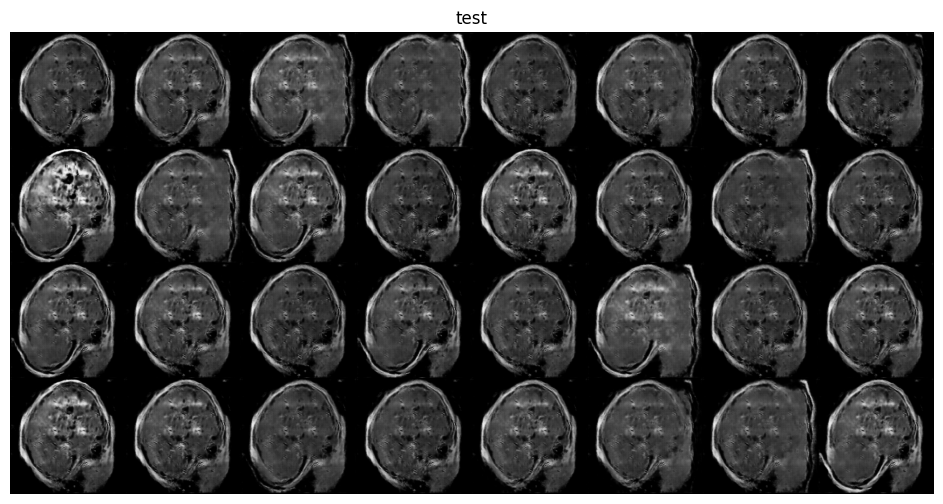

In [61]:
with torch.no_grad():
                    fake = gen(fixed_noise)
                    image_grid_fake = torchvision.utils.make_grid(fake, normalize=True)

                    plt.figure(figsize=(12, 6))
                    plt.imshow(image_grid_fake.permute(1, 2, 0).cpu())
                    plt.title(f"test")
                    plt.axis('off')
                    plt.show()

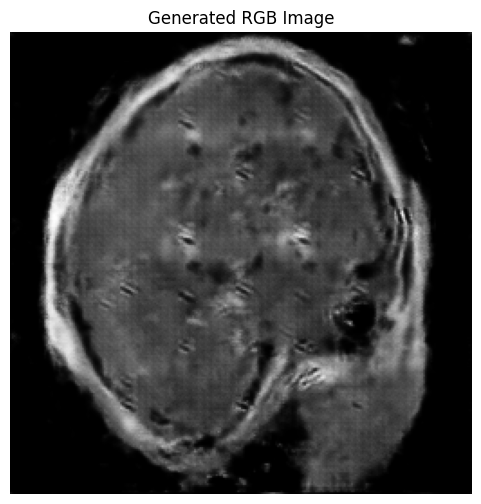

In [69]:
with torch.no_grad():
    fake = gen(fixed_noise[0].unsqueeze(0)) 

# Visualize the image
plt.figure(figsize=(6, 6))
plt.imshow(fake_image.permute(1, 2, 0).cpu(),cmap='gray')
plt.title("Fake Mages")
plt.axis('off')
plt.show()